In [75]:
from math import *
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import uniform
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [76]:
def prior_sample(seed):
    # Sample from prior distribution
    # For univariate alpha-stable models, sample each parameter from its respective uniform distribution
    np.random.seed(seed)
    alpha = uniform.rvs(1.1, 0.9)  # U[1.1, 2]
    beta = uniform.rvs(-1, 2)  # U[-1, 1]
    gamma = uniform.rvs(0, 300)  # U[0, 300]
    delta = uniform.rvs(-300, 600)  # U[-300, 300]
    return [alpha, beta, gamma, delta]

In [77]:
def univ_alpha_stable_sampler(params,size,seed) :
    alpha,beta,gamma,delta = params[0],params[1],params[2],params[3]
    #print(alpha,beta,gamma,delta)
    y_bar = 0
    np.random.seed(seed)
    w = np.random.standard_exponential(size=size)
    u = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = size)
    if alpha == 1 :
        y_bar = (2/np.pi)*((np.pi/2+beta*u)*np.tan(u)-beta*np.log((np.pi/2*w*np.cos(u))/(np.pi/2+beta*u)))
        return gamma*y_bar + delta
    else :
        S = (1+(beta**2)*(np.tan(np.pi*alpha/2)**2))**(1/(2*alpha))
        B = (1/alpha)*np.arctan(beta*np.tan(np.pi*alpha/2))
        z = np.cos(u-alpha*(u+B))/w
        y_bar = (S*(np.sin((alpha)*(u+B)))*np.sign(z)*(np.abs(z)**((1-alpha)/alpha)))/(np.cos(u)**(1/alpha))
        return gamma*y_bar + delta

In [154]:
def prior(theta):
    if 1.1 <= theta[0] <= 2.0 and -1 <= theta[1] <=1 and 0 <= theta[2] <= 300 and -300 <= theta[3] <= 300:
        return 1
    else:
        return 0

In [148]:
def transition(theta, cov):
    return theta+multivariate_normal(mean=[0,0,0,0], cov=cov).rvs()

In [80]:
gamma = 10
def compute_quantiles(data):
    # Compute quantile-based summary statistics
    quantiles = np.percentile(data, [5, 25, 50, 75, 95])
    v_alpha = (quantiles[4] - quantiles[0]) / (quantiles[3] - quantiles[1])
    v_beta = (quantiles[4] + quantiles[0] - 2 * quantiles[2]) / (quantiles[4] - quantiles[0])
    v_gamma = (quantiles[3] - quantiles[1]) / gamma
    return v_alpha, v_beta, v_gamma

In [81]:
def S(data):
    # Compute summary statistics of the data
    # This function should return low-dimensional summary statistics S(data)
    # For univariate alpha-stable models, use quantile-based estimators along with the mean of the data
    v_alpha, v_beta, v_gamma = compute_quantiles(data)
    mean_x = np.mean(data)
    return np.array([v_alpha, v_beta, v_gamma, mean_x])

In [82]:
def sigma_hat(theta_hat, size, n_draws = 1000):
    x = np.array([univ_alpha_stable_sampler(theta_hat, size=size, seed=None) for _ in range(n_draws)])
    sumary_statistics = np.array([S(x_i) for x_i in x])
    return np.cov(sumary_statistics, rowvar=False)

In [83]:
def norm2(u) :
    return np.sqrt(np.sum(u*u))

In [135]:
def K(u, sigma) :
    d = sigma.shape[0]
    #print(d)
    return np.exp(-(u.T@np.linalg.inv(sigma)@u)/2)

In [151]:
alpha = 1.7
beta = 0.9
gamma = 10
delta = 10

def MCMC(N, size, covariance=np.diag([0.25, 0.25, 1, 1]), seed=42):
    #epsilons = [1000-0.01*k for k in range(100000)]
    epsilon = 0.1
    y = levy_stable.rvs(alpha, beta, loc=gamma, scale=delta, size=size)
    theta0 = prior_sample(seed)
    thetas = [theta0] * N
    #weights = []
    #x = univ_alpha_stable_sampler(theta0, size=size, seed=seed)
    #sigma0 = sigma_hat(theta0, size=size, n_draws = 1000)
    #weights.append(K((S(x)-S(y))/epsilons[0], sigma0))
    n = 0
    n_accepted = 0
    while n<N-1:
        theta = np.array(thetas[n])
        theta_new = transition(theta, cov=covariance)
        prior_new = prior(theta_new)
        h = 0
        if prior_new != 0:
            x_new = univ_alpha_stable_sampler(theta_new, size=size, seed=seed)
            sigma = sigma_hat(theta_new, size=size, n_draws = 1000)
            #epsilon = epsilons[n]
            w = K((S(x_new)-S(y)), sigma)
            if w < epsilon:
                #h = min(1, w/weights[-1])
                h=1
        u = np.random.uniform(0.0, 1.0)
        if u < h :
            n_accepted += 1
            thetas[n+1] = theta_new
            #weights.append(K((S(x_new)-S(y))/epsilon, sigma))
        else:
            thetas[n+1] = theta
        n += 1
    rate = n_accepted/N
    return thetas, rate

In [ ]:
thetas1, rate1= MCMC(N=100000, size=1000)

In [123]:
alphas = [theta[0] for theta in thetas[10000:]]
betas = [theta[1] for theta in thetas[10000:]]
gammas = [theta[2] for theta in thetas[10000:]]
deltas = [theta[3] for theta in thetas[10000:]]

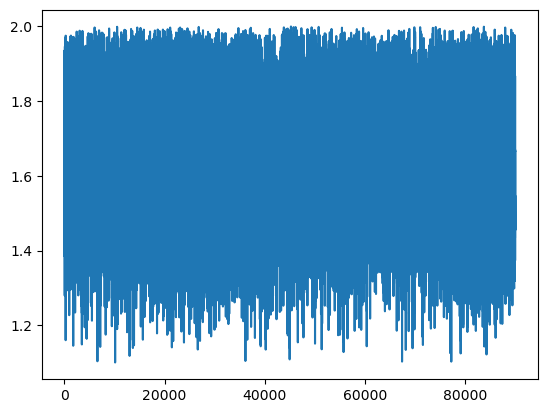

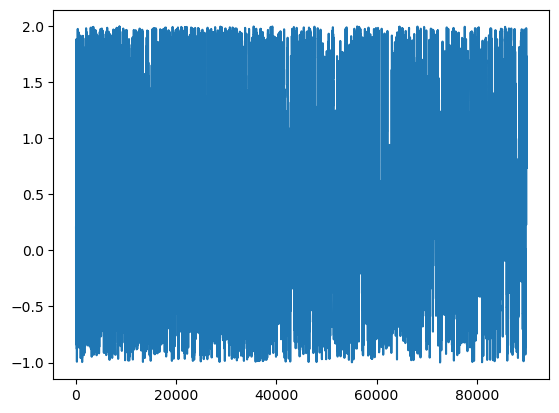

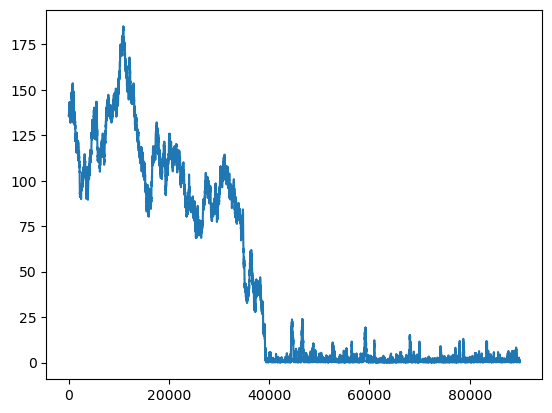

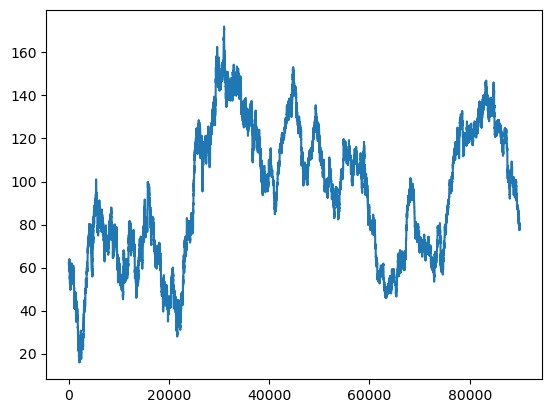

In [133]:
n = np.linspace(0, 90000, 90000)
plt.plot(n, alphas)
plt.show()
plt.plot(n, betas)
plt.show()
plt.plot(n, gammas)
plt.show()
plt.plot(n, deltas)
plt.show()

In [127]:
# Estimation of parameters

alpha_hat = np.mean(alphas)
beta_hat = np.mean(betas)
gamma_hat = np.mean(gammas)
delta_hat = np.mean(deltas)

In [125]:
print(alpha_hat)

1.6385552498605798


In [128]:
print(beta_hat)

0.5086084199943841


In [129]:
print(gamma_hat)

45.91651703724569


In [134]:
print(delta_hat)

94.21571816965518


In [141]:
# Root Mean squared error

y = levy_stable.rvs(alpha, beta, loc=gamma, scale=delta, size=1000)
theta_hat = [alpha_hat, beta_hat, gamma_hat, delta_hat]
y_hat = univ_alpha_stable_sampler(theta_hat, size=1000, seed=42)
MSE = np.sum(((y-y_hat)**2)/1000)
RMSE = np.sqrt(MSE)
print(RMSE)

169.2522629466355


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe80128c210>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe80128d510>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe8022cdc50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe80128e3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe80128eb90>],
 'means': []}

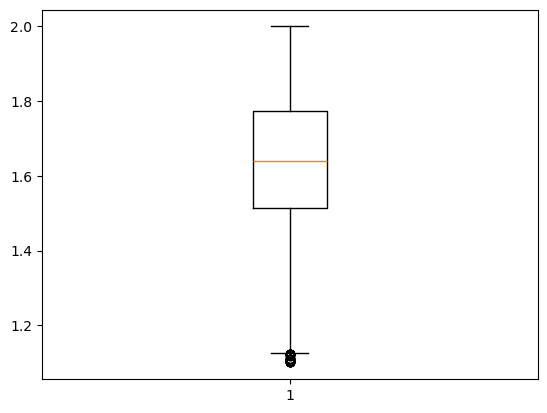

In [137]:
plt.boxplot(alphas)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe80288d9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe81088db50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe80128db50>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe801249490>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe801248c10>],
 'means': []}

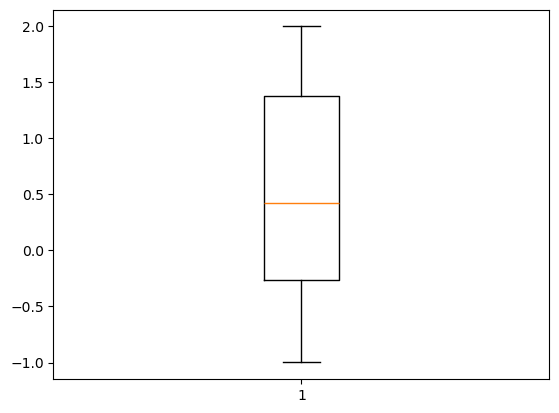

In [138]:
plt.boxplot(betas)